# BGSE Summer School, July 2021: Semantics and Word vectors

In [1]:
# Import packages
import os
import re
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Sklearn
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Gensim
import gensim
from gensim.models import Word2Vec

# nltk
import nltk
from nltk.stem import SnowballStemmer
from nltk import sent_tokenize
from nltk.corpus import stopwords

# Shuffle
from random import shuffle

from tqdm import tqdm
tqdm.pandas()

In [2]:
# Change your main directory accordingly
basedir = Path(os.environ['SUMMER_SCHOOL']) / 'Day5'
datadir = basedir / 'data'
utildir = basedir / 'utils'
os.chdir(basedir)

A large part of the existing literature focuses on using the occurrence of specific words within a text corpus to perform downstream natural language processing tasks, from topic classification to cosine similarity and sentiment analysis. 

In this exercise, we show a simple instance of [word2vec](https://en.wikipedia.org/wiki/Word2vec), which can be used to extract intended meanings from complex phrases. The idea is to create numerical arrays, or *word embeddings* for every word in a large corpus. Each word is assigned its own vector in such a way that words that frequently appear together in the same context are given vectors that are close together. The result is a model that may not know what a "queen" is, but does know that "queen" is closer in context to "prince" than "queenfish".

It is important to note that *building* useful models takes a long time - hours or days to train a large corpus. An alternative is to import an existing model trained with word2vec - such as spaCy's large lexicons - which depending on the task or size of the data you want to process will be more efficient than training a model. In what follows, we will perform a mock training of a word embedding model using word2vec and our sample of reuters articles.

# word2vec
A particular application of word embedding methods was popularized by [Mikolov et al 2013](https://arxiv.org/abs/1301.3781), which in particular propose two methods: CBOW and continuous skip-grams. Focusing on the latter, their idea was to train a model on a sliding window of words surrounding each word in your corpus, so that given any word the model would be able to predict its neighboring terms. This framework for learning word vectors can be largely summarized in a series of steps:
- Load in a large corpus of text
- Create a vector representation of every word in the corpus' vocabulary both as a center word $w_I$ and as a context word $w_o$
- Iterate through each position (word) in the text, look at the words comprised within the window
- Use the similarity of the context and center word vectors to compute a probability of a context word appearing given a center word
- Adjust these word vectors to increase the model's ability to predict context words

An example of the slidding window looks as follows:
<br>
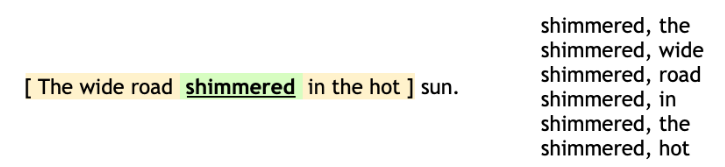
<br>
The key goal of the model is to learn the hidden layer that will map an input vector - a one-hot-representation of a center word - to a series of output vectors - the one-hot-representations of the context words. Graphically, a model that predicts the next word would thus look like this:
<div>
<img src="https://lilianweng.github.io/lil-log/assets/images/word2vec-skip-gram.png" alt="Drawing" style="width: 500px;"/><br>
</div>
The hidden layer corresponds to the $h$ vector, which is naught but the $W$ matrix row that corresponds to the input $x_i$ - here, the center word $w_I$. This vector can then be mapped to a one-hot vector after passing an output layer: this will be the *word* the model predicts, which above corresponds to $y_j$ - here, the context word $w_o$.

In the simplest specification of the model, the output layer is a softmax regression classifier, which transforms the dot-product of the hidden layer and the corresponding row in the output matrix and maps it to a probabilty distribution between 0 and 1. The training objective of the skip-gram model is thus to maximize the probability of predicting context words given the target word. For a sequence of words in T, the objective can be written (after taking logs):
<br>
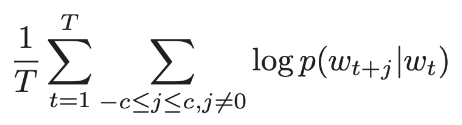
<br>
And, following the logic of the sliding window and the softmax classifier, the probability of a context word $w_o$ occuring given a center word $w_I$ is 
<br>
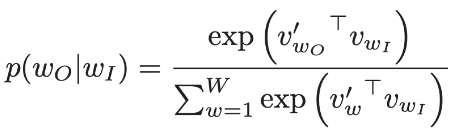
<br>
The dot-product multiplication of the hidden layer and the context-weights row in $W^{\prime}$ - which in the function corresponds to $v'_o$ - is done for each word and <code>context,word</code> pair. The probability that a word belongs with a set of context words is then obtained by passing the softmax classifier. Lastly, we apply stochastic gradient descent to update the values of the weights in the two layers (the hidden layer and the output or softmax layer) in case the machine didn't predict the word correctly and nudge our model closer to a local optimum. Graphically, the process looks as follows:
<br>
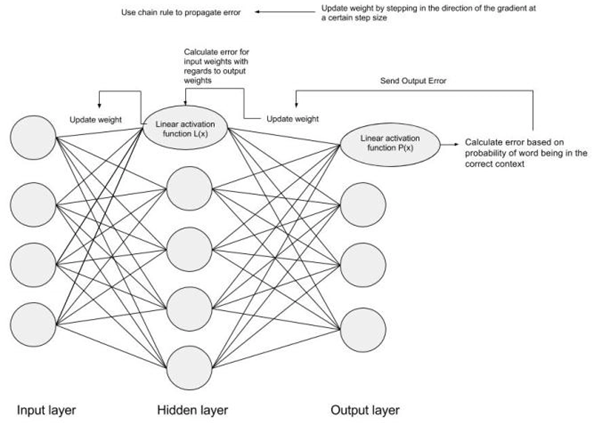
<br>
Note that when all is said and done, words that are used in similar situations will likely share similar neighboring words and the hidden vectors that will be built will thus be similar. At the core, this is the definition of similarity we obtain using word2vec: as first hinted above, the model will suggest the words "queen" and "prince" are similar since both are surrounded by regal terms. Conversely, the words "queenfish" and "queen" will be identified as holding little resemblance due to the fact that they are used in very different contexts. It follows that, mathematically, the hidden layer vectors of "queen" and "prince" will be similar but those of "queen" and "queenfish" will not. 

## A first example

In [7]:
# Pre-processing steps
remove_punct = str.maketrans('','','!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~“”’–')
stop_words   = set(stopwords.words('english'))
stemmer      = SnowballStemmer('english')

In [8]:
# Pre-processing function
def normalize_text(doc):
    """Takes documents as input and outputs clean tokens"""
    
    lower      = doc.lower()                                             # all lower case
    nopunc     = lower.translate(remove_punct)                           # remove punctuation
    words      = nopunc.split()                                          # split into tokens
#     nostop     = [w for w in words if w not in stop_words]               # remove stopwords
    preproc    = [w for w in words if not w.isdigit()]                  # normalize numbers
    
    return preproc

In [9]:
with open(datadir / 'text_example.txt', encoding='utf-8') as f:
    text = f.read()

In [10]:
text = normalize_text(text)

print(text)

['in', 'however', 'signs', 'that', 'the', 'expansion', 'might', 'be', 'coming', 'to', 'an', 'end', 'started', 'to', 'appear', 'us', 'housing', 'prices', 'which', 'had', 'doubled', 'since', 'started', 'declining', 'interest', 'rates', 'were', 'stable', 'but', 'economists', 'started', 'to', 'worry', 'optimists', 'believed', 'that', 'although', 'lower', 'housing', 'prices', 'might', 'lead', 'to', 'lower', 'housing', 'construction', 'and', 'to', 'lower', 'spending', 'by', 'consumers', 'the', 'fed', 'the', 'short', 'name', 'for', 'the', 'us', 'central', 'bank', 'formally', 'known', 'as', 'the', 'federal', 'reserve', 'board', 'could', 'lower', 'interest', 'rates', 'to', 'stimulate', 'demand', 'and', 'avoid', 'a', 'recession', 'interest', 'rates', 'pessimists', 'believed', 'that', 'the', 'decrease', 'in', 'interest', 'rates', 'might', 'not', 'be', 'enough', 'to', 'sustain', 'demand', 'and', 'that', 'the', 'united', 'states', 'may', 'go', 'through', 'a', 'short', 'recession', 'even', 'the', 'p

In [11]:
from scipy.spatial.distance import cosine

In [12]:
WINDOW = 3

In [13]:
# Allows skipgram to learn what are context words vs. non-context words
NEGATIVE_SAMPLES = 3

In [27]:
data = []

# Iterate over center words
for i, center_w in tqdm(enumerate(text[WINDOW-1:-WINDOW])):
    
    # For each center word, extract context words
    context_wds = [
        context_word
        for context_word 
        in text[i:i+2*WINDOW-1] 
        if context_word != center_w
    ]
    
    # For each of your context words
    for w in context_wds:
        data.append([center_w, w, 1])
        
        # Negative samples
        negative_samples = np.random.choice(
            [
                k for k in text[WINDOW-1:-WINDOW] 
                if k != center_w
                and k not in context_wds
            ],
            NEGATIVE_SAMPLES
        )
        
        for samp in negative_samples:
            data.append([center_w, samp, 0])

0it [00:00, ?it/s]


In [15]:
df = pd.DataFrame(columns=['center_word', 'context_word', 'target'], data=data)
words = np.intersect1d(df.context_word, df.center_word)
df = df.loc[(df.center_word.isin(words)) & (df.context_word.isin(words))].reset_index(drop=True)

In [29]:
df.head(10)

,center_word,context_word,target
0,signs,in,1
1,signs,from,0
2,signs,went,0
3,signs,poor,0
4,signs,however,1
5,signs,of,0
6,signs,many,0
7,signs,crisis,0
8,signs,that,1
9,signs,other,0


In [17]:
df.shape

(16744, 3)

In [18]:
len(text)

1055

### Activation function

In [30]:
def sigmoid(v, scale=1):
    res = 1 / (1 + np.exp(-scale*v))
    return res

In [31]:
def normalize_data(data):
    row_norms = np.sqrt((data.values**2).sum(axis=1)).reshape(-1,1)
    return data.divide(row_norms, axis='index')

### Iteration

In the above, we performed negative sampling, which allows us the algorithm what are not context words. Intuitively, without negative sampling this exercise would be akin to trying to classify cats and dogs from pictures with only cat pictures in it. Now we can actually run through the word2vec update and backpropagation algorithm, which consists of a handful steps:

    - for (main, context) in D:
        - Score = sigmoid($V_{emb} x V_{ctx})
        - Error = Label - Score
        - Update:
            - if error > 0, move closer together
            - if error < 0, move further apart


In [32]:
def iterate_embeddings(df, embedding_matrix, context_matrix, learning_rate, debug):
    
    # Pick principal embedding and corresponding context embeddings
    embedding_matrix_center = embedding_matrix.loc[df.center_word].values  # Center vectors from df
    context_matrix_context = context_matrix.loc[df.context_word].values    # Context vectors from df
    
    # Compute similarities, scores, and errors between main embeddings and corresponding context embeddings
    dot_products = np.sum(embedding_matrix_center * context_matrix_context, axis=1)
    scores = sigmoid(dot_products)                                         # Sigmoid scores
    errors = (df.target - scores).values.reshape(-1,1)                     # Error, direction
    diffs = context_matrix_context - embedding_matrix_center               # Difference between each vector pair
    
    # Updates (not backpropagation)
    upd = diffs*errors*learning_rate                                       # Update each center-context pair given their relative distance, iteration error and learning rate
    new_df = pd.DataFrame(upd)                                             # Define dataframe with the updates 
    new_df['center_word'] = df.center_word                                 # Add column with center_word (since these are 'exploded' above, connection is 1-to-1)
    new_df['context_word'] = df.context_word                               # Add column with context word
    new_df_center = new_df.groupby('center_word').sum()                    # Aggregate all changes on word central embedding
    new_df_context = new_df.groupby('context_word').sum()                  # Aggregate all changes on word context embedding

    # Use to plot
    plot_words(debug)
    
    # Pass updates
    embedding_matrix += new_df_center.loc[embedding_matrix.index]          # Update by adding the previous vector with the sum of changes
    context_matrix -= new_df_context.loc[context_matrix.index]             # Update
    
    # Normalize embeddings
    embedding_matrix = normalize_data(embedding_matrix)
    context_matrix = normalize_data(context_matrix)
    
    # Return new embeddings
    return embedding_matrix, context_matrix

In [37]:
def plot_words(debug):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    
    # First plot
    lim_0 = embedding_matrix.loc[[debug[0]]]                                        # vector for first word to plot
    lim_1 = embedding_matrix.loc[[debug[1]]]                                        # vector for second word to plot
    
    # First plot: First word
    p1 = ax1.scatter(lim_0[0], lim_0[1], color='b')                                 # Plot vector in 2-D space
    ax1.arrow(0,0,float(lim_0[0]), float(lim_0[1]), length_includes_head=True)      # Plot arrow that connects center with the vector head
    ax1.text(lim_0[0], lim_0[1], list(lim_0.index)[0])                              # Add name give x-y coordinates
        
    # First plot: Second word
    p2 = ax1.scatter(lim_1[0], lim_1[1], color='b')
    ax1.arrow(0,0,float(lim_1[0]), float(lim_1[1]), length_includes_head=True)
    ax1.text(lim_1[0], lim_1[1], list(lim_1.index)[0])
        
    sim = 1 - cosine(embedding_matrix.loc[debug[0]], embedding_matrix.loc[debug[1]]) # Compute similarity = 1 - Distance
    ax1.set_title('Sim = %s'%round(sim,4), fontsize=20)                              # Aesthetics
    ax1.axvline(0, color='k', linestyle='--', alpha=0.5)
    ax1.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    t = np.arange(0, 3.14*2+0.1, 0.1)
    ax1.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    ax1.axis('off')

    # Embedding vs. context for same word 
    
    # Second plot
    lim_embedd = embedding_matrix.loc[[debug[0]]]
    lim_context = context_matrix.loc[[debug[0]]]
    
    # Second plot: First word
    p1 = ax2.scatter(lim_embedd[0], lim_embedd[1], color='b')
    ax2.arrow(0,0,float(lim_embedd[0]), float(lim_embedd[1]), length_includes_head=True)
    ax2.text(lim_embedd[0], lim_embedd[1], list(lim_embedd.index)[0])
    
    # Second plot: Second word
    p2 = ax2.scatter(lim_context[0], lim_context[1], color='r')
    ax2.arrow(0,0,float(lim_context[0]), float(lim_context[1]), length_includes_head=True)
    ax2.text(lim_context[0], lim_context[1], list(lim_context.index)[0])
        
    sim = 1 - cosine(embedding_matrix.loc[debug[0]], context_matrix.loc[debug[1]])
    ax2.set_title('Sim = %s'%round(sim,4), fontsize=20)
    ax2.axvline(0, color='k', linestyle='--', alpha=0.5)
    ax2.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    ax2.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    ax2.axis('off')

    plt.show()

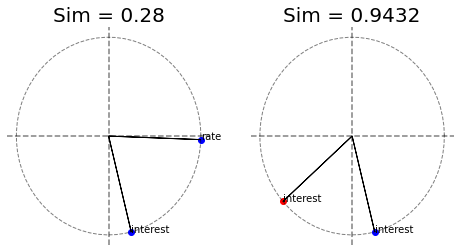

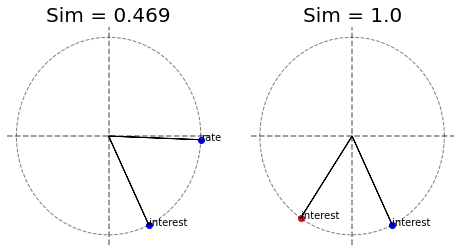

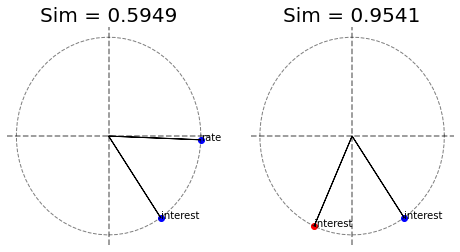

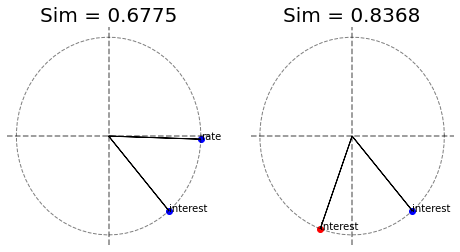

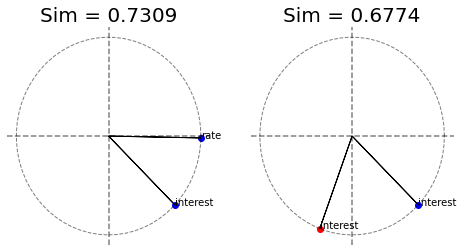

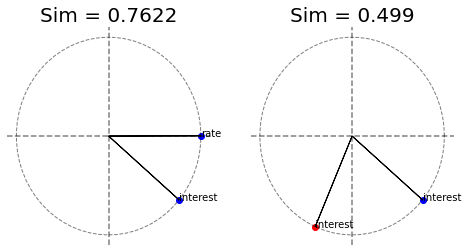

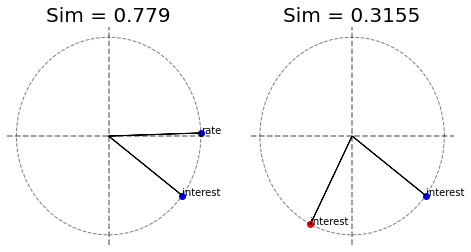

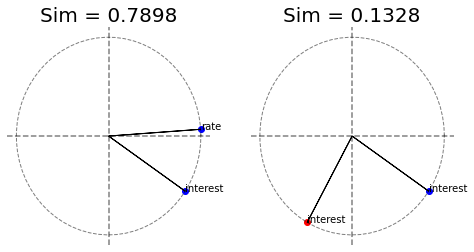

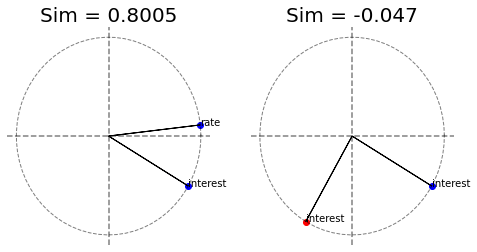

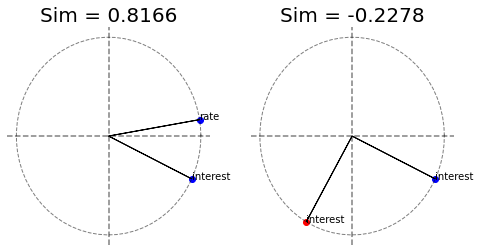

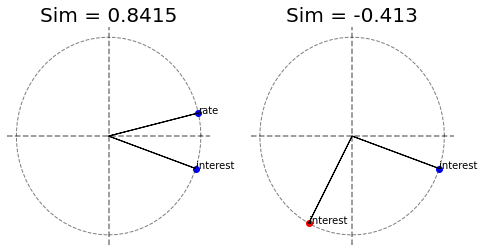

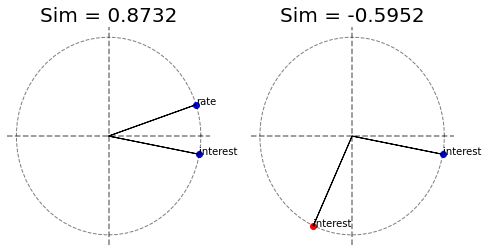

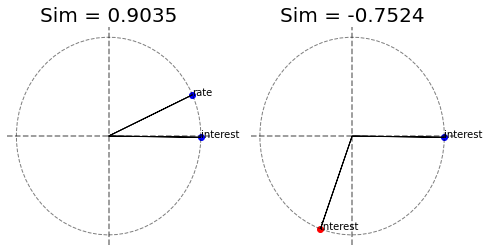

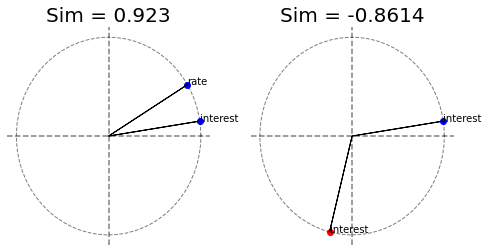

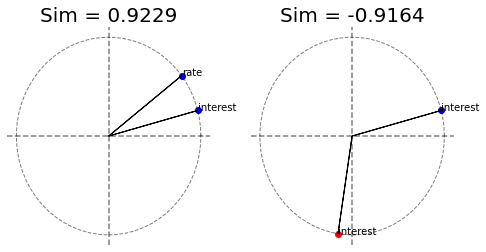

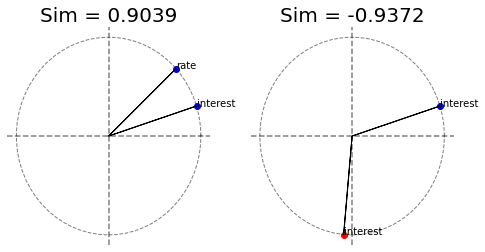

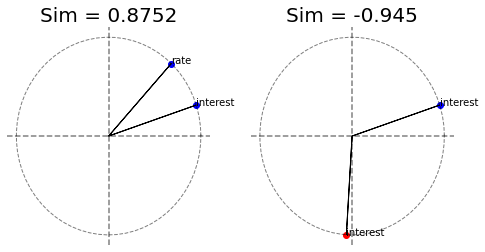

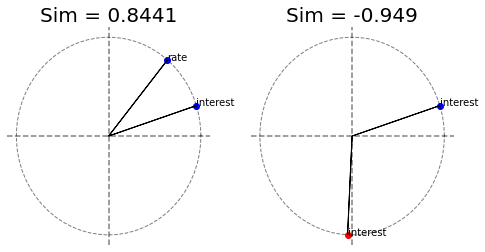

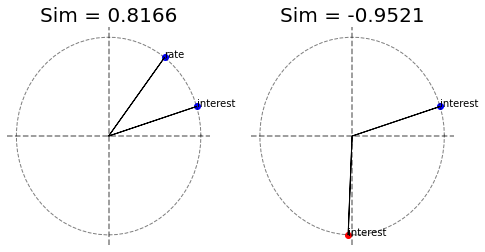

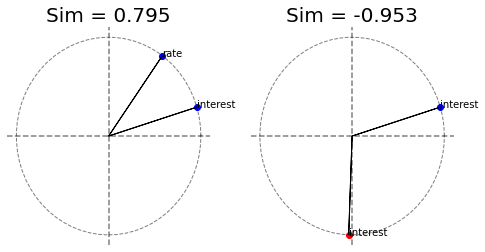

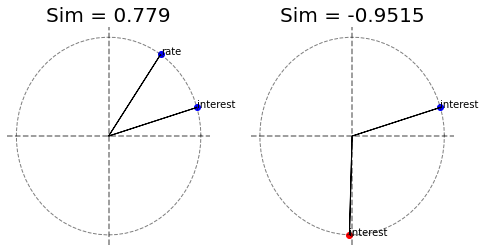

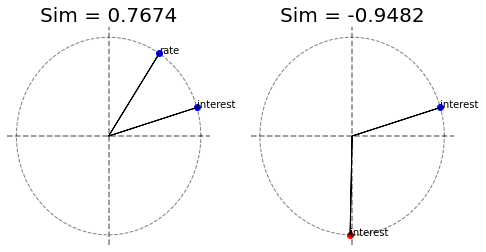

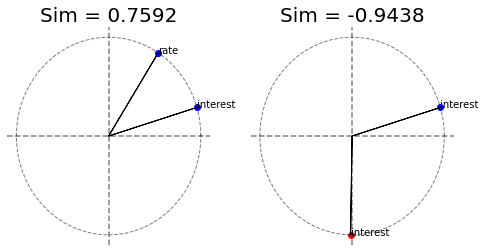

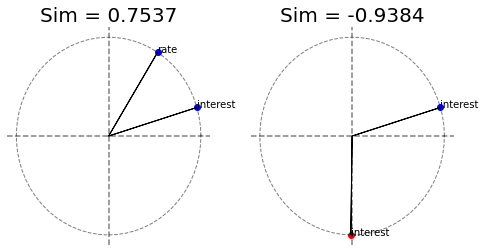

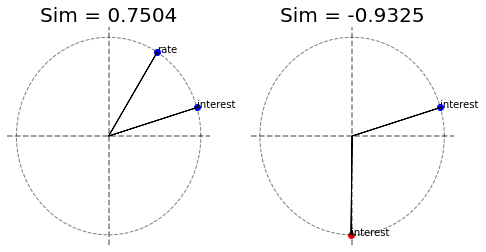

In [39]:
EMBEDDING_SIZE = 2

# Initialize embeddings
embedding_matrix = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))  # random x-y assignment
row_norms = np.sqrt((embedding_matrix**2).sum(axis=1)).reshape(-1,1)     # normalize (keeps things tidy)
embedding_matrix /= row_norms

context_matrix = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((context_matrix**2).sum(axis=1)).reshape(-1,1)
context_matrix /= row_norms

embedding_matrix = pd.DataFrame(data=embedding_matrix, index=words)
context_matrix = pd.DataFrame(data=context_matrix, index=words)

for _ in range(25):
    embedding_matrix, context_matrix = iterate_embeddings(df, embedding_matrix, context_matrix, 0.1, ['interest', 'rate'])

In [40]:
embedding_matrix.loc[embedding_matrix.index.isin(['interest','rate'])]

,0,1
interest,0.957585,0.288150
rate,0.525944,0.850519


In [41]:
list_ = []
for w1 in words:
    for w2 in words:
        if w1 != w2:
            sim = 1 - cosine(embedding_matrix.loc[w1], embedding_matrix.loc[w2])
            list_.append((w1,w2,sim))
sorted([item for item in list_ if item[0] == 'mortgage'], key=lambda t: -t[2])[:10]

[('mortgage', 'expansion', 0.9999972459737086),
 ('mortgage', 'complex', 0.9999914640777471),
 ('mortgage', 'main', 0.999959601845756),
 ('mortgage', 'recovered', 0.9999587257082428),
 ('mortgage', 'particular', 0.9998535304375598),
 ('mortgage', 'reduced', 0.9998485262984201),
 ('mortgage', 'levels', 0.9998445806957653),
 ('mortgage', 'tour', 0.999732802270143),
 ('mortgage', 'viewpoint', 0.9996350289479005),
 ('mortgage', 'fear', 0.9996221708348968)]

In [20]:
tsne = TSNE(n_components=2, verbose=1, random_state=42, angle=.99, init='pca')

# As with most sklearn tools, "fit()" calculates the parameters of any technique whereas "transform()" applies it on data
X_tsne = tsne.fit_transform(embedding_matrix.values)
words_used = embedding_matrix.index

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 377 samples in 0.001s...
[t-SNE] Computed neighbors for 377 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 377 / 377
[t-SNE] Mean sigma: 0.042394
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.827789
[t-SNE] KL divergence after 1000 iterations: 0.122209


In [21]:
tsne_df = pd.DataFrame(X_tsne, index=words_used, columns=['x', 'y'])

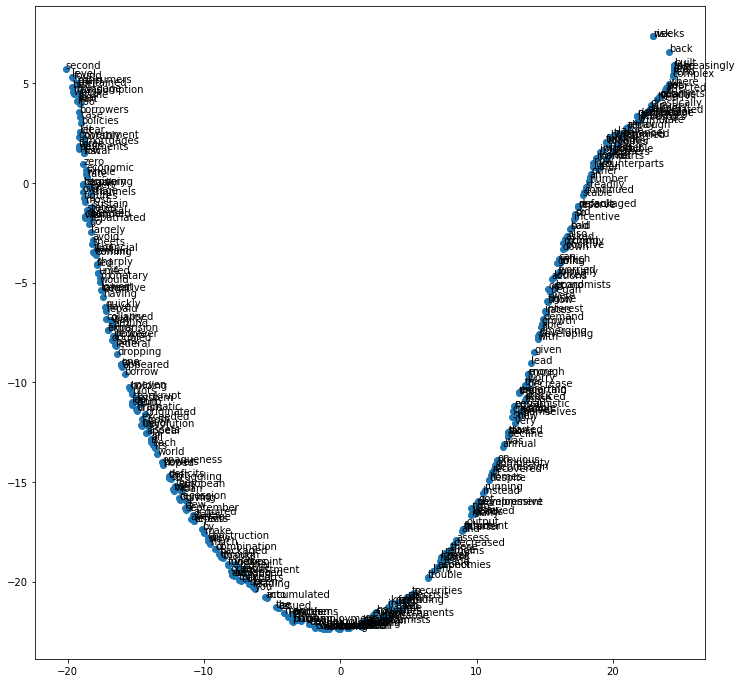

In [22]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(tsne_df['x'], tsne_df['y'])

for word, pos in tsne_df.iterrows():
        ax.annotate(word, pos)

### Train a model

In [50]:
COLS = [
    'date',
    'author',
    'title',
    'article',
    'section',
    'publication'
]

TYPES = {
    'date': str,
    'author': str,
    'title': str,
    'article': str,
    'section': str,
    'publication': str
}

In [43]:
from utils.loader import dataLoad

# Read article data
df = dataLoad(file=datadir / 'reuters_news.csv', cols=COLS, types=TYPES)

# Drop NaN articles
df.dropna(subset=['article'], inplace=True)

<AxesSubplot:xlabel='date', ylabel='Count'>

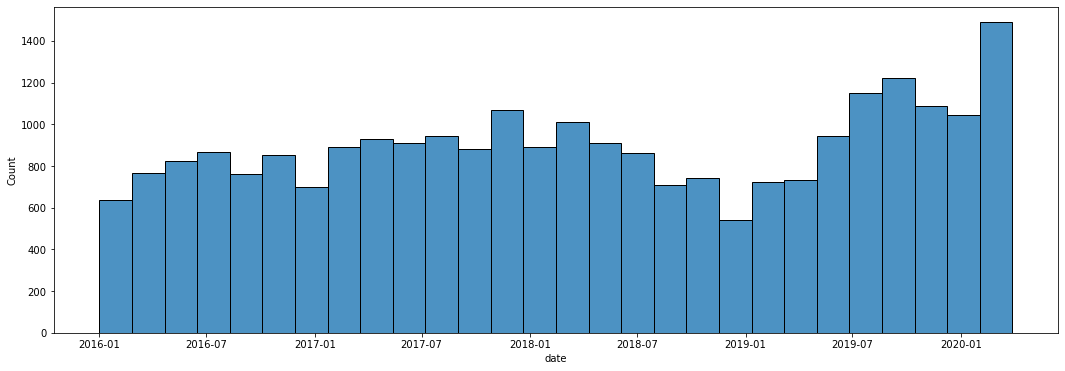

In [44]:
# Check time distribution of articles
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

fig, axes = plt.subplots(1, 1, figsize=(18, 6))

sns.histplot(                                                # Seaborn histogram
    ax=axes,                                                 # axes position to occupy
    data=df, x="date",                                       # data to use, define x
    alpha=.8, linewidth=1,                                   # Aesthetics
)

In [45]:
# Check the first article, as well as a handful of entries
print(df['article'].iloc[0])
df.head()

MELBOURNE (Reuters) - Tiger Woods’ Presidents Cup debut at Royal Melbourne in 1998 was soured by the United States’ only defeat to the Internationals in the biennial tournament’s 25-year history. Twenty-one years later, Woods’ debut as U.S. captain got off to a horror start at the same course on Thursday as Ernie Els’s Internationals drew inspiration from the 1998 victors. The Internationals roared to a 4-1 lead after the opening fourball matches, pumped up by a motivational video featuring players from the Peter Thomson-captained team that claimed a 20.5-11.5 win over the U.S. at the sandbelt course. Apart from Els, Thomson’s Internationals featured other Hall of Fame players including Greg Norman, Vijay Singh and Nick Price. Their tips on how to beat the U.S. at Royal Melbourne proved invaluable on day one. Taking inspiration from the video, a fired-up Abraham Ancer teamed with Louis Oosthuizen to rout Dustin Johnson and Gary Woodland 4&3. “It pumped me up, man,” debutant Ancer, the 

,date,author,title,article,section,publication
0,2019-12-12,Ian Ransom,Internationals inspired by video tips from '98...,MELBOURNE (Reuters) - Tiger Woods’ Presidents ...,sports news,Reuters
1,2017-04-07,NaN,BRIEF-Beijing Capital Development's Q1 contrac...,April 7 (Reuters) - Beijing Capital Developmen...,financials,Reuters
2,2018-12-26,NaN,Trump 'very happy' with Treasury chief Mnuchin...,WASHINGTON (Reuters) - U.S. President Donald T...,politics,Reuters
3,2016-01-28,NaN,IOC executive Anita DeFrantz joins LA Olympic bid,(Reuters) - International Olympic Committee ex...,sports news,Reuters
4,2016-10-07,NaN,BRIEF-Acrinova sells 15% of its holding in Bri...,Oct 7 (Reuters) - Acrinova AB (publ) : * Says ...,financials,Reuters



As in many other text analysis tasks, one can greatly improve the quality and performance of any model by clearing its input data. In particular, for our corpus of data we will 
- transform all upper case characters to **lower case** characters 
- remove any **punctuation** characters
- drop **stopwords**, words that appear frequently in texts but that add little to the training of any model
- optionally, we can also **stem** words, so that *economies* and *economy* are read as the same word given its root *econom*.

We will do so by pre-defining the functions we will pass our data through. This process is not exhaustive and many alternatives are plausible. For example, when only interested in word occurences one can build all pre-processing steps on sklearn's CountVectorizer directly. 

In [46]:
def get_sentences(doc):
    """Takes documents as input, splits it at the sentence level and passes the pre-processing function"""
    
    sent=[]
    
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
        
    return sent

In [47]:
# Get parsed sentences from articles
df['sentence'] = df.article.progress_apply(lambda row: get_sentences(row))
df_xpld = df.explode('sentence').reset_index(drop=True)

# Shuffles the list of split sentences - Necessary to compute stochastic gradient descent
sentences = df_xpld['sentence'].tolist()
shuffle(sentences)

100%|██████████████████████████████████████████████████████████████████████████| 25090/25090 [00:16<00:00, 1566.16it/s]


Before moving on, let's have a quick look at what data we have produced. In the example sentence below, we can see lists of tokens corresponding to each sentence, which have had all 'nuisance' characters removed.

In [48]:
# First sentence
sentences[0]

['to',
 'me',
 'the',
 'main',
 'thing',
 'is',
 'just',
 'having',
 'my',
 'groceries',
 'delivered',
 'to',
 'my',
 'door',
 'she',
 'said']

Note that so far there is nothing new about what we are doing. All the steps above are common to most count-based methods. They are also common to those models whose objective is to reduce dimensionality, like PCA or topic models. However, whereas these models use term-document or topic-document frequencies to map a vector of words to a lower-dimensional space, with *word embeddings* we aim at better understanding which words tend to appear under similar contexts.


## Building your own model
We will now implement the word2vec model to the corpus of Reuters articles we cleaned in the first section of the notebook. word2vec uses a single hidden layer, fully connected neural network, as shown in the graph above for the one-step-ahead prediction. The input consists of the list of tokenized sentences and the size of the input and output vectors is identical and corresponds to the corpus vocabulary $V$. The size of the hidden layer is a hyperparameter and as such is manually set. The same applies to the window size.

In [49]:
# Pass in the Word2Vec function from GENSIM package

w2v = Word2Vec(
    sentences,      # List of tokenized sentences
    workers = 8,    # Number of threads to run in parallel
    size = 300,     # Word vector dimensionality     
    min_count = 10, # Minimum word count 
    window = 5,     # Context window size (how far does w2v look at either side)     
    sample = 0.75,  # Downsample setting for frequent words - Mikolov et al chose 0.75, but this has been contested
)

In [56]:
# Overwrites the raw, un-normed vectors
w2v.init_sims(replace=True)

# Save the data as a pickle
w2v.save(str(datadir / 'w2v-vectors.pkl'))

<br>Let's first take a look at the size $V$ of our vocabulary. 

In [57]:
# Check for the length of V
word_vectors = w2v.wv
print('Size of the vocabulary:',len(word_vectors.vocab))

Size of the vocabulary: 25069


<br>Let's also investigate the hidden vector that corresponds to the word *economy*, $h_{economy}$

<br>We can also check for how similar words are by computing the cosine similarity of words

In [59]:
# Similarity between two close synonyms (higher is more similar - dot product)
word_vectors.similarity('increase','rise')

0.8473147

In [62]:
# Similarity between two antonyms who likely share very similar contexts
word_vectors.similarity('increase','decline')

0.79660463

In [63]:
# Similarity between two unrelated words
word_vectors.similarity('increase','screen')

0.32257476

In [65]:
# Similarity between two words that show up together often
word_vectors.similarity('donald','trump')

0.26146787

In [66]:
# Similarity between two words that show up together often
word_vectors.similarity('tankers','supertankers')

0.7312206

In [67]:
# Similarity between two words that show up together often
word_vectors.similarity('exports','shipments')

0.8782379

<br>We can also look for words that are the most similar to any given word, and we can infer vectors by adding & subtracting related vectors

In [69]:
# Analogy: Paris is to France what ___ is to Italy
word_vectors.most_similar(positive=['paris','italy'], negative=['france'])

[('berlin', 0.7925456762313843),
 ('doha', 0.7819706201553345),
 ('vienna', 0.769912838935852),
 ('rome', 0.7617373466491699),
 ('brussels', 0.7597867846488953),
 ('seoul', 0.7504806518554688),
 ('dublin', 0.7440191507339478),
 ('milan', 0.734167218208313),
 ('budapest', 0.725963830947876),
 ('sydney', 0.725520133972168)]

We can also predict the center word given the context terms, useful for text completion analysis.

In [71]:
print(w2v.predict_output_word(['robust', 'growth', 'american', 'employment'], topn=3))

[('economic', 7.632976e-05), ('growth', 6.852305e-05), ('economy', 6.285946e-05)]


## Plot your word data
We can also plot our data by further reducing the hidden layer dimensions down to 2D or 3D. In order to do so, we use **t-SNE**, which is short for [t-Distributed Stochastic Neighbor Embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding). Although an explanation of the inner-workings of t-SNE is beyond the scope of this notebook, the main gist is that the algorithm models each high-dimensional object by a 2D or 3D point in a way that similar objects are modeled by points close together and different objects are modeled by points far apart with high probability. 

In [72]:
n=150

In [73]:
# List of word names
vocab = word_vectors.index2word[:n]

# List of word vectors
X = word_vectors[vocab]

# 2D t-SNE
tsne = TSNE(n_components=2, verbose=1, random_state=42, angle=.99, init='pca')

# As with most sklearn tools, "fit()" calculates the parameters of any technique whereas "transform()" applies it on data
X_tsne = tsne.fit_transform(X)
X_tsne.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 150 samples in 0.000s...
[t-SNE] Computed neighbors for 150 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 150 / 150
[t-SNE] Mean sigma: 0.445553
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.395309
[t-SNE] KL divergence after 1000 iterations: 0.468748


(150, 2)

<br>We can now visualize a handful of words using *matplotlib.pyplot*. Note how words are bunched together in ways that convey similarity in meaning and context.

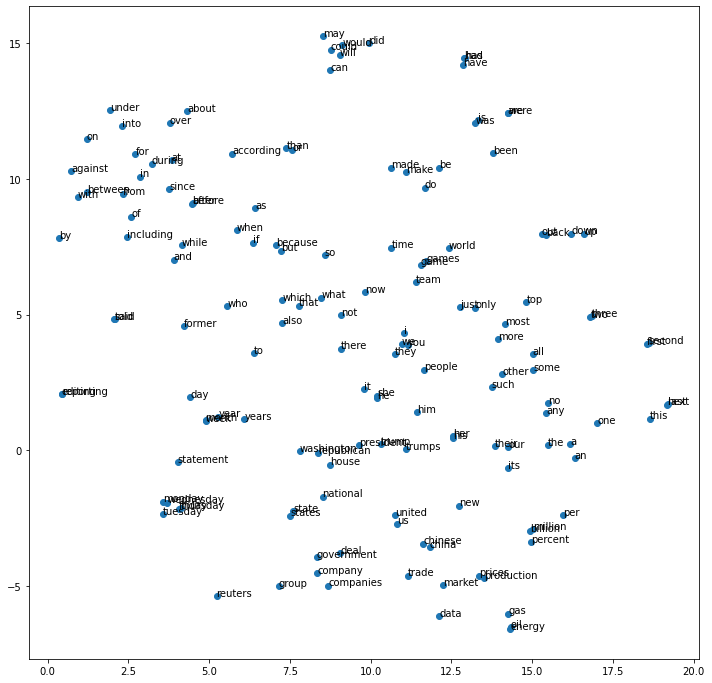

In [74]:
df2 = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df2['x'], df2['y'])

for word, pos in df2.iterrows():
    ax.annotate(word, pos)

### K-means clustering and word2vec
In addition, we can cluster words given their vector similarities, which provides a more nuanced view of the different categories our data may comprise. 

In [76]:
# Define the K-means clustering object - and the number of clusters.
kmw = KMeans(n_clusters=20)

# Fit the K-means model to our w2v vectors
kmw.fit(word_vectors.vectors[:n])

# We can check the words in the cluster of any word
word_ex = 'said'
word_clust = kmw.labels_[word_vectors.vocab[word_ex].index]
print(f'Words in the cluster of {word_ex}:')
for i, cluster in enumerate(kmw.labels_):
    if cluster == word_clust:
        print('     ',word_vectors.index2word[i])

Words in the cluster of said:
      said
      told
      made


In [77]:
# The labels are mere number categories, but we could identify patterns and rename these
labels = kmw.labels_
print(labels)

[19  9 10 16 17 19 10 16 10 12  3 16  8  3 11 10  8 16 14 11 19  0 14  9
 16 19  6 19 11  3  8  5  9 14  1 15  0 15  4 11  0 10  6 13  2 11  5  3
  8  4 19  8 11 18  3  2 19 17 16  6  3  2 16  4 13  9  6  3 18  2  1  2
 10 12  3  2  6 13 16  1 11 17 10  6 17 19  1 11 16 19  9  2 13 10  6  4
 17  3  6  9 16 13 11 17 17  7  9 15 11  7  0  6  7 18  6  5 19  3 18 18
 19  6 13  7  2 12 11 13 11  6  6  2  1  3  4  7 13 16 10  7  2  4  0 10
  6 11  4  0 17  1]


In [78]:
reindex= dict(zip(word_vectors.index2word[:n], range(len(word_vectors.index2word[:n]))))

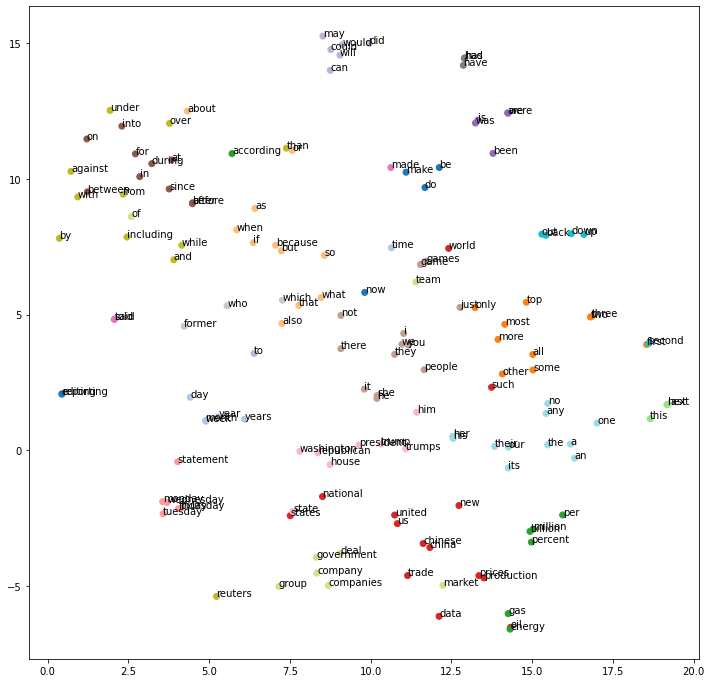

In [79]:
import matplotlib.cm as cm

# Plot our words again using the t-SNE 2D vectors
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df2['x'], df2['y'], c=kmw.labels_.astype(float), cmap=cm.tab20)
    
for word, pos in df2.iterrows():
    ax.annotate(word, pos)

### Semantic relationships between words

In [80]:
cit_cou = ['rome', 'italy', 'berlin', 'germany', 'paris', 'france', 'budapest', 'hungary', 'brussels', 'belgium', 'athens', 'greece', 'madrid', 'spain']

In [81]:
# List of word names
vocab = word_vectors.index2word[:5000]

# List of word vectors
X = word_vectors[vocab]

# 2D t-SNE
tsne = TSNE(n_components=2, verbose=1, random_state=42, angle=.99, init='pca')

# As with most sklearn tools, "fit()" calculates the parameters of any technique whereas "transform()" applies it on data
X_tsne = tsne.fit_transform(X)
X_tsne.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.281s...
[t-SNE] Computed neighbors for 5000 samples in 14.817s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.316580
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.556908
[t-SNE] KL divergence after 1000 iterations: 1.850926


(5000, 2)

<br>We can now visualize a handful of words using *matplotlib.pyplot*. Note how words are bunched together in ways that convey similarity in meaning and context.

In [82]:
df2 = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df2 = df2.loc[df2.index.isin(cit_cou)]

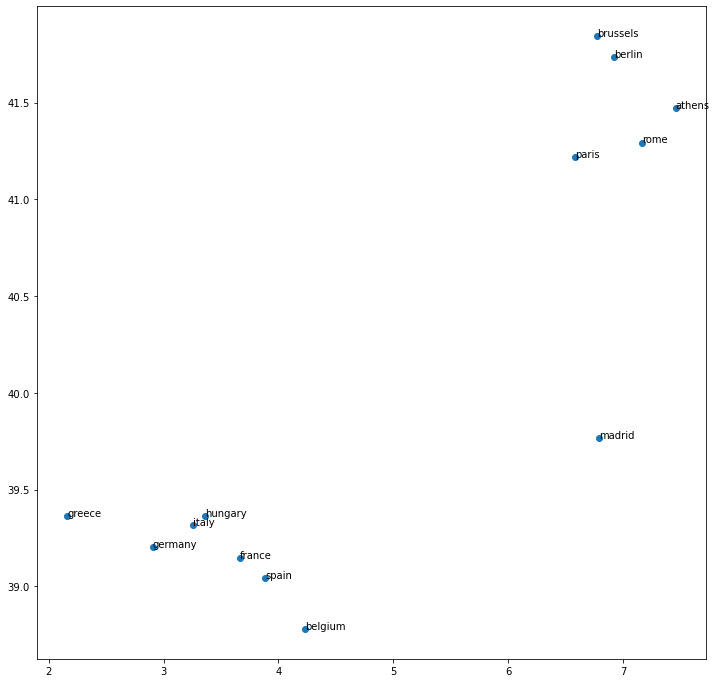

In [83]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df2['x'], df2['y'])

for word, pos in df2.iterrows():
        ax.annotate(word, pos)

## Application: Predictions on embeddings

In [84]:
def make_sent_vec(voc, w2v_model=w2v, num_features=300):
    """
    Parse sentences into a vector
    """
    feature_vec = np.zeros((num_features,), dtype="float32")
    n = 0
    index_set = set(word_vectors.index2word)

    for word in voc:
        if word in index_set: 
            n += 1
            feature_vec = np.add(feature_vec, w2v_model[word])
    
    feature_vec = np.divide(feature_vec, n)
    return feature_vec

### Can do better: doc2vec

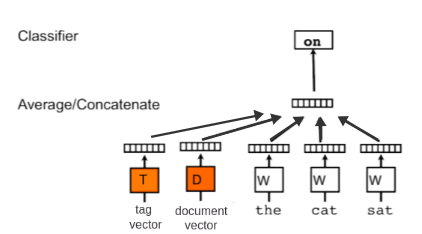

Le and Mikolov in 2014 introduced the [Doc2Vec algorithm](https://cs.stanford.edu/~quocle/paragraph_vector.pdf), which usually outperforms such simple-averaging of Word2Vec vectors.

The basic idea is: act as if a document has another floating word-like vector, which contributes to all training predictions, and is updated like other word-vectors, but we will call it a doc-vector. Gensim’s Doc2Vec class implements this algorithm.

In [85]:
from gensim.models.doc2vec import TaggedDocument

# Parse data to format readable by gensim
df['flatten'] = df.sentence.progress_apply(lambda row: [item for sublist in row for item in sublist])
df['tagged_doc'] = df.progress_apply(lambda row: TaggedDocument((row.flatten), tags=[row.name]), axis=1)

100%|█████████████████████████████████████████████████████████████████████████| 25090/25090 [00:00<00:00, 54895.29it/s]


In [88]:
from sklearn.model_selection import train_test_split

# train_test_split returns two dataframes
train_df, test_df = train_test_split(df, random_state=42, test_size=0.1, shuffle=False)

train_x = train_df['sentence']
test_x = test_df['sentence']

train_y = train_df['section']
test_y = test_df['section']

train_df = train_df.copy()
test_df = test_df.copy()

train_corpus = train_df['tagged_doc'].values

In [89]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [90]:
from gensim.models.doc2vec import Doc2Vec

d2v_model = Doc2Vec(dm=1, vector_size=100, window=2, min_count=10, sample=1e-4, workers=8, epochs=10)

In [91]:
d2v_model.build_vocab([x for x in train_corpus])

2021-07-09 15:40:56,301 : INFO : collecting all words and their counts
2021-07-09 15:40:56,302 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-07-09 15:40:57,002 : INFO : PROGRESS: at example #10000, processed 3282990 words (4706565/s), 73233 word types, 10000 tags
2021-07-09 15:40:57,705 : INFO : PROGRESS: at example #20000, processed 6493520 words (4568674/s), 101630 word types, 20000 tags
2021-07-09 15:40:57,900 : INFO : collected 107896 word types and 22581 unique tags from a corpus of 22581 examples and 7354809 words
2021-07-09 15:40:57,901 : INFO : Loading a fresh vocabulary
2021-07-09 15:40:57,993 : INFO : effective_min_count=10 retains 23779 unique words (22% of original 107896, drops 84117)
2021-07-09 15:40:57,995 : INFO : effective_min_count=10 leaves 7160758 word corpus (97% of original 7354809, drops 194051)
2021-07-09 15:40:58,058 : INFO : deleting the raw counts dictionary of 107896 items
2021-07-09 15:40:58,061 : INFO : sample=0.0001 

In [93]:
d2v_model.train(train_corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

2021-07-09 15:41:30,156 : INFO : training model with 8 workers on 23779 vocabulary and 100 features, using sg=0 hs=0 sample=0.0001 negative=5 window=2
2021-07-09 15:41:31,179 : INFO : EPOCH 1 - PROGRESS: at 14.11% examples, 568755 words/s, in_qsize 15, out_qsize 0
2021-07-09 15:41:32,183 : INFO : EPOCH 1 - PROGRESS: at 28.82% examples, 585036 words/s, in_qsize 15, out_qsize 0
2021-07-09 15:41:33,200 : INFO : EPOCH 1 - PROGRESS: at 43.74% examples, 591016 words/s, in_qsize 15, out_qsize 0
2021-07-09 15:41:34,201 : INFO : EPOCH 1 - PROGRESS: at 58.48% examples, 591485 words/s, in_qsize 15, out_qsize 0
2021-07-09 15:41:35,213 : INFO : EPOCH 1 - PROGRESS: at 73.72% examples, 594823 words/s, in_qsize 15, out_qsize 0
2021-07-09 15:41:36,214 : INFO : EPOCH 1 - PROGRESS: at 88.64% examples, 595429 words/s, in_qsize 15, out_qsize 0
2021-07-09 15:41:37,073 : INFO : worker thread finished; awaiting finish of 7 more threads
2021-07-09 15:41:37,077 : INFO : worker thread finished; awaiting finish o

In [94]:
d2v_model.infer_vector(['oil', 'prices', 'increased', 'today'])

array([ 0.05718895, -0.05012135, -0.08024389,  0.00730316, -0.00630617,
        0.04039089,  0.09446322, -0.02284635, -0.05277637,  0.01979336,
       -0.02514334, -0.03377171, -0.03851634,  0.01003614, -0.10040158,
        0.01104216,  0.07549331, -0.07205852,  0.00752241,  0.04724872,
       -0.0486913 , -0.00983648,  0.02792003,  0.03540349,  0.05980494,
        0.00475543,  0.09788749, -0.02817384, -0.04602811, -0.01088811,
        0.05906314, -0.03639038, -0.02118022,  0.04116069, -0.02278773,
       -0.03363149,  0.01829688, -0.11095105, -0.00405001,  0.01528802,
       -0.10452169,  0.0338122 ,  0.02296722, -0.01610802, -0.03888367,
        0.07422212,  0.00029305, -0.01683121,  0.03344924,  0.0202902 ,
        0.02249327, -0.03831219,  0.03476686, -0.04191212, -0.04594962,
        0.0690203 ,  0.07552334, -0.05470463,  0.01561187, -0.00874337,
        0.08984974, -0.03110098, -0.01773859, -0.02185982,  0.03578087,
       -0.04978493,  0.07556422,  0.06604329, -0.02163761, -0.06

#### Performance on its own data 

In [95]:
ranks = []

for doc_id in tqdm(range(len(train_corpus))):
    inferred_vector = d2v_model.infer_vector(train_corpus[doc_id].words)
    sims = d2v_model.docvecs.most_similar([inferred_vector], topn=len(d2v_model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    
    if doc_id==300:
        break

  1%|█                                                                             | 300/22581 [00:13<16:12, 22.91it/s]


In [96]:
import collections

counter = collections.Counter(ranks)
print(counter)

Counter({0: 297, 1: 2, 3: 1, 21: 1})


#### Test the model

In [97]:
unseen_text = 'The season of fourth-quarter earnings reports has begun and already companies are beating expectations. But that\'s not necessarily good news for stocks, as those expectations are very low. Wall Street slashed profit estimates over the last three months as the index lost 6.8 percent. The consensus estimate for fourth quarter S&P 500 growth has fallen to 11.9 percent from 17.8 percent in September, data from FactSet shows. Preliminary earnings results are already showing earnings beats, RBC Capital Markets strategist Lori Calvasina said in a note to investors on Tuesday. But those better-than-expected results represent companies stepping over a very low bar. \"The tone around demand and the underlying backdrop has rattled US equity investors,\" Calvasina said. Apple confirmed what many feared when it announced lowered revenue guidance for the upcoming quarter. Even if Apple were to beat expectations, the damage to the stock was done earlier this month following the lowered guidance. Morgan Stanley strategist Michael Wilson said he expects more \"Apple-like price reactions to guidance cuts\" when companies report. \"We would expect negative guidance revisions to be a persistent theme during 4Q earnings season,\" Wilson said. Even with the diminished expectations, Bank of America Merrill Lynch\'s Savita Subramanian said instances of companies beating expectations will be smaller and fewer. Her analysis shows that even the slashed estimates may not be enough, as Subramanian said "more estimate cuts are likely" for fourth quarter profits.'

test_example = normalize_text(unseen_text)

In [98]:
inferred_vector = d2v_model.infer_vector(test_example)

In [100]:
inferred_vector

array([-0.23734057,  0.2783259 ,  0.21088967,  1.0071918 , -0.18152574,
       -0.11350092,  0.3764065 ,  0.7388882 , -0.18158099, -0.03623805,
        0.4663811 , -0.4663007 ,  0.41763872,  0.07385811, -0.20869426,
        0.5305515 , -0.05926261, -0.53946066, -0.0679777 , -0.01974987,
        0.11510088,  0.02624373, -0.52045965, -0.23996013,  0.60288656,
       -0.15784423,  0.45232767, -0.0903339 , -0.32944956, -0.00437842,
        0.3148938 , -0.23414192,  0.7981755 ,  0.22102751,  0.40533248,
       -0.12280386,  0.4623142 ,  0.21115084, -0.03593433,  0.23394863,
        0.5376048 ,  0.47344103, -0.43549448, -0.5143164 , -0.25764444,
        0.08605272,  0.05274557,  0.5692108 , -0.4006368 ,  0.2682474 ,
       -0.4266989 ,  0.27223507, -0.10008466,  0.46308136, -0.4873132 ,
        0.3666955 ,  0.21535166, -0.36054283,  0.12067581,  0.8635611 ,
        0.45250538,  0.151501  ,  0.60593253, -0.27683872,  0.5962893 ,
       -0.12763187,  0.14108682,  0.22938053, -0.37003407, -0.29

In [101]:
sims = d2v_model.docvecs.most_similar([inferred_vector], topn=len(d2v_model.docvecs))

In [103]:
# Compare and print the most/least similar documents from the train corpus
print('Test Document: «%s»\n' % ' '.join(test_example))
print(u'Similar Models %s:\n' % d2v_model)
for label, index in [('MOST', 0), ('SECOND MOST', 1), ('THIRD MOST', 2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(train_corpus[sims[index][0]].words)))

Test Document: «the season of fourthquarter earnings reports has begun and already companies are beating expectations but thats not necessarily good news for stocks as those expectations are very low wall street slashed profit estimates over the last three months as the index lost percent the consensus estimate for fourth quarter sp growth has fallen to percent from percent in september data from factset shows preliminary earnings results are already showing earnings beats rbc capital markets strategist lori calvasina said in a note to investors on tuesday but those betterthanexpected results represent companies stepping over a very low bar the tone around demand and the underlying backdrop has rattled us equity investors calvasina said apple confirmed what many feared when it announced lowered revenue guidance for the upcoming quarter even if apple were to beat expectations the damage to the stock was done earlier this month following the lowered guidance morgan stanley strategist mic

## Random Forest Classification

### Split, Cross-Validate, Train, Predict 

In [104]:
train_df['vector'] = train_df.progress_apply(lambda row: d2v_model.infer_vector(row['flatten']), axis=1)

100%|███████████████████████████████████████████████████████████████████████████| 22581/22581 [01:36<00:00, 234.82it/s]


In [105]:
test_df

,date,author,title,article,section,publication,sentence,flatten,tagged_doc
22581,2017-04-21,Osamu Tsukimori,Russian energy minister says oil market situat...,TOKYO (Reuters) - Russian Energy Minister Alex...,commodities,Reuters,"[[tokyo, reuters, russian, energy, minister, a...","[tokyo, reuters, russian, energy, minister, al...","([tokyo, reuters, russian, energy, minister, a..."
22582,2017-03-06,NaN,BRIEF-Aurelius Equity Opportunities FY revenue...,March 6 (Reuters) - Aurelius Equity Opportunit...,financials,Reuters,"[[march, reuters, aurelius, equity, opportunit...","[march, reuters, aurelius, equity, opportuniti...","([march, reuters, aurelius, equity, opportunit..."
22583,2018-06-21,Michael Church,Iran's Ezatolahi ready to take his chances aga...,"KAZAN, Russia (Reuters) - Saeid Ezatolahi will...",sports news,Reuters,"[[kazan, russia, reuters, saeid, ezatolahi, wi...","[kazan, russia, reuters, saeid, ezatolahi, wil...","([kazan, russia, reuters, saeid, ezatolahi, wi..."
22584,2018-09-19,NaN,India cenbank says Yes Bank's Kapoor can remai...,Sept 19 (Reuters) - India’s central bank has a...,financials,Reuters,"[[sept, reuters, indias, central, bank, has, a...","[sept, reuters, indias, central, bank, has, al...","([sept, reuters, indias, central, bank, has, a..."
22585,2019-11-12,John Kemp,"Oil price risks shift to the upside, funds con...",LONDON (Reuters) - Hedge funds continued to bu...,commodities,Reuters,"[[london, reuters, hedge, funds, continued, to...","[london, reuters, hedge, funds, continued, to,...","([london, reuters, hedge, funds, continued, to..."
...,...,...,...,...,...,...,...,...,...
25085,2016-04-26,NaN,Akamai's revenue beat estimates on higher clou...,"(Reuters) - Akamai Technologies Inc, a provide...",technology news,Reuters,"[[reuters, akamai, technologies, inc, a, provi...","[reuters, akamai, technologies, inc, a, provid...","([reuters, akamai, technologies, inc, a, provi..."
25086,2019-02-01,NaN,Trump says U.S. trade delegation to visit Chin...,BEIJING (Reuters) - A U.S. trade delegation wi...,politics,Reuters,"[[beijing, reuters, a, us, trade, delegation, ...","[beijing, reuters, a, us, trade, delegation, w...","([beijing, reuters, a, us, trade, delegation, ..."
25087,2020-01-21,NaN,Vodafone Group exits Facebook-led Libra curren...,(Reuters) - Britain’s Vodafone Group PLC (VOD....,technology news,Reuters,"[[reuters, britains, vodafone, group, plc, vod...","[reuters, britains, vodafone, group, plc, vodl...","([reuters, britains, vodafone, group, plc, vod..."
25088,2018-10-11,"Ron Bousso, Dmitry Zhdannikov",Big Oil still reluctant to open spending taps:...,LONDON (Reuters) - Energy companies and invest...,commodities,Reuters,"[[london, reuters, energy, companies, and, inv...","[london, reuters, energy, companies, and, inve...","([london, reuters, energy, companies, and, inv..."


In [107]:
test_df.dropna(subset=['flatten'], inplace=True)

test_df['vector'] = test_df.progress_apply(lambda row: d2v_model.infer_vector(row['flatten']), axis=1)

100%|█████████████████████████████████████████████████████████████████████████████| 2509/2509 [00:11<00:00, 227.56it/s]


In [108]:
X_train = train_df.vector.tolist()
y_train = train_df.section.tolist()

X_test = test_df.vector.tolist()
y_test = test_df.section.tolist()

In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [72]:
grid = {'n_estimators': [100, 200], 'max_depth': list(range(4,8))}
model_cv = GridSearchCV(RandomForestClassifier(), param_grid=grid, cv=2)
model_cv.fit(X_train,train_y)

model_cv.get_params()

{'cv': 2,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(),
 'iid': 'deprecated',
 'n_jobs': None,
 'param_grid': {'n_estimators': [100, 200], 'max_depth': [4, 5, 6, 7]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [111]:
import time

scikit_RF = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
)

start = time.time()
model_RF = scikit_RF.fit(X_train, y_train)
end = time.time()

RF_time = end - start

In [112]:
RF_score = model_RF.score(X_test, y_test)
print('Accuracy of RandomForest: %.3f' % RF_score)

Accuracy of RandomForest: 0.924


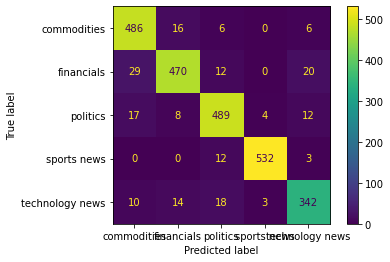

In [113]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test, model_RF.predict(X_test))
cmp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=model_RF.classes_
)
cmp.plot()

In [114]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model_RF.predict(X_test), target_names=model_RF.classes_))

                 precision    recall  f1-score   support

    commodities       0.90      0.95      0.92       514
     financials       0.93      0.89      0.90       531
       politics       0.91      0.92      0.92       530
    sports news       0.99      0.97      0.98       547
technology news       0.89      0.88      0.89       387

       accuracy                           0.92      2509
      macro avg       0.92      0.92      0.92      2509
   weighted avg       0.92      0.92      0.92      2509



### Academic applications → slides